<a href="https://colab.research.google.com/github/anshVerma02/image_Enhance/blob/main/U_W_E_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 888.jpg to 888.jpg


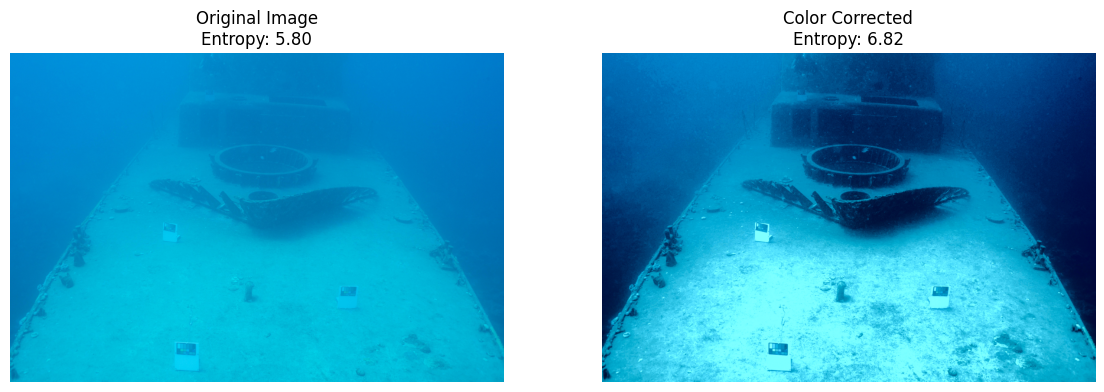

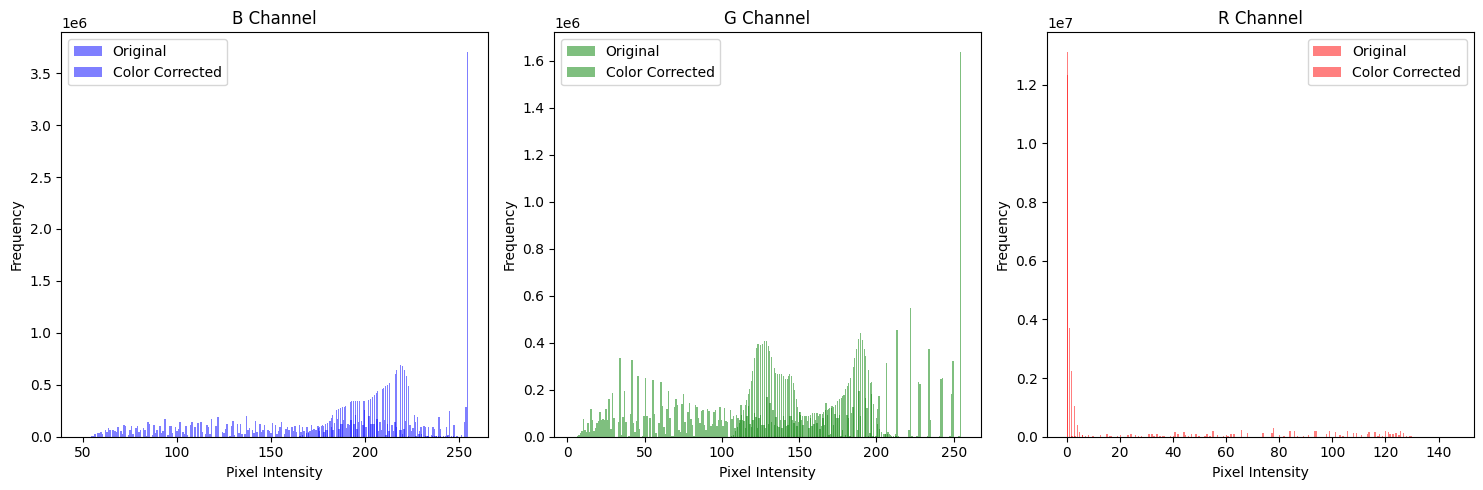

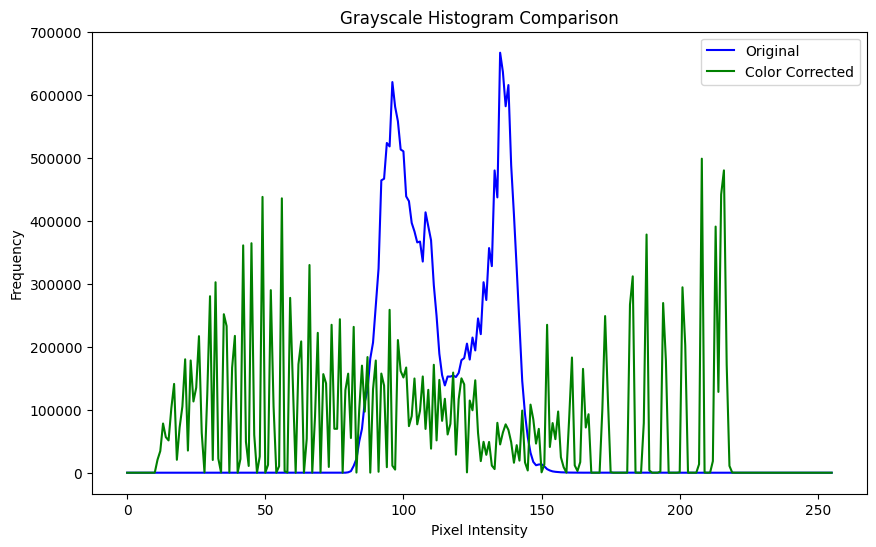

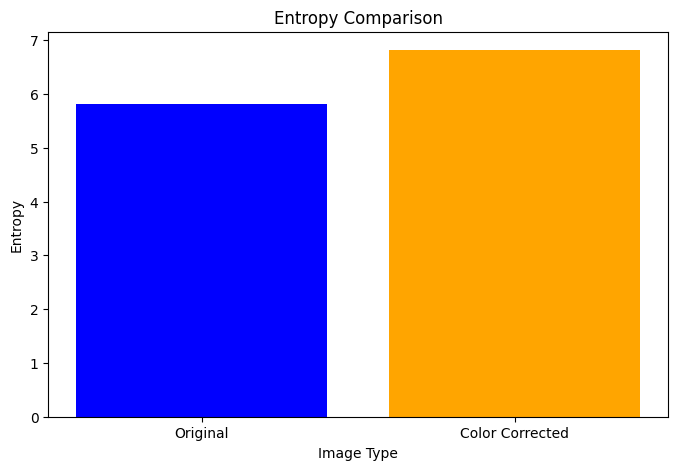

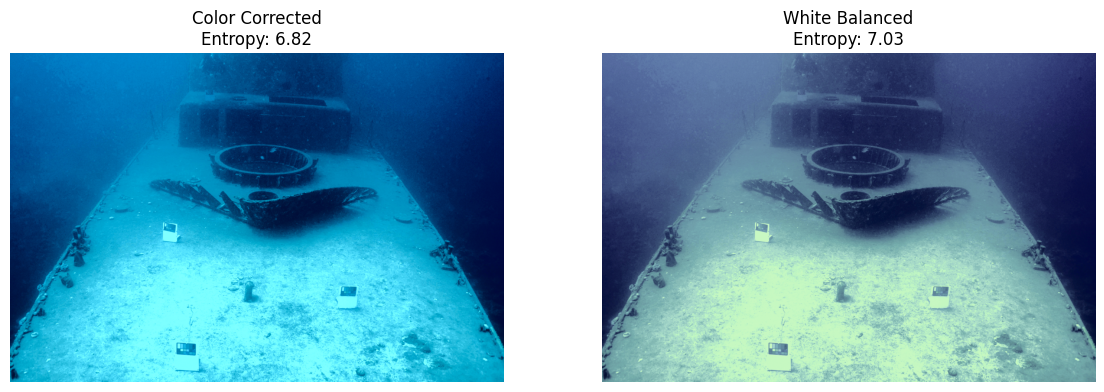

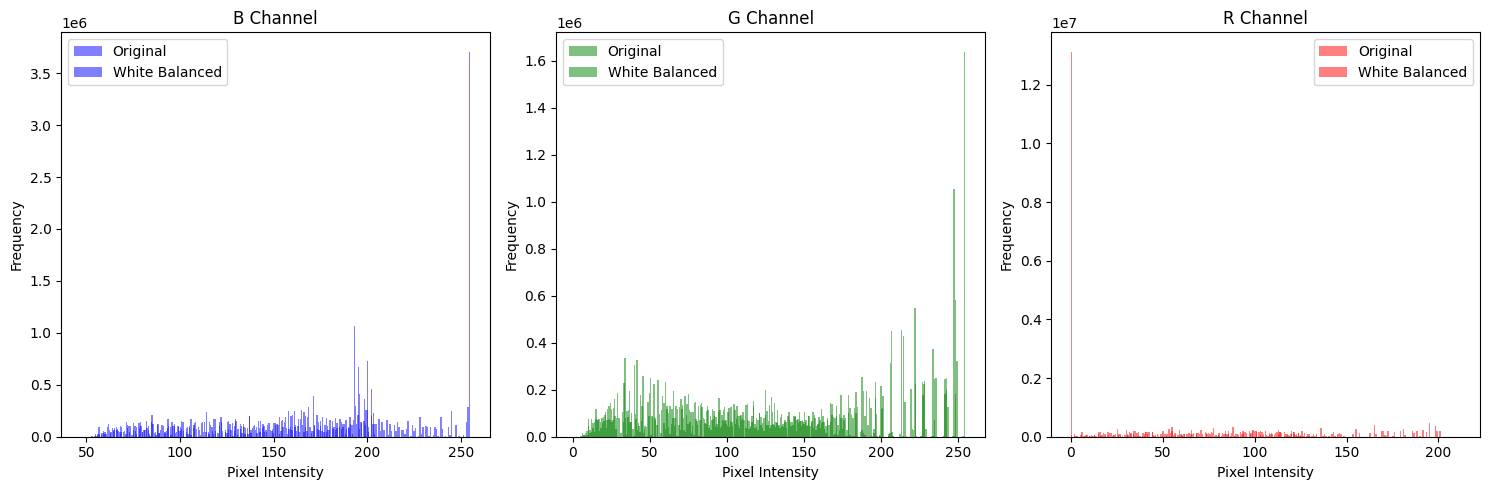

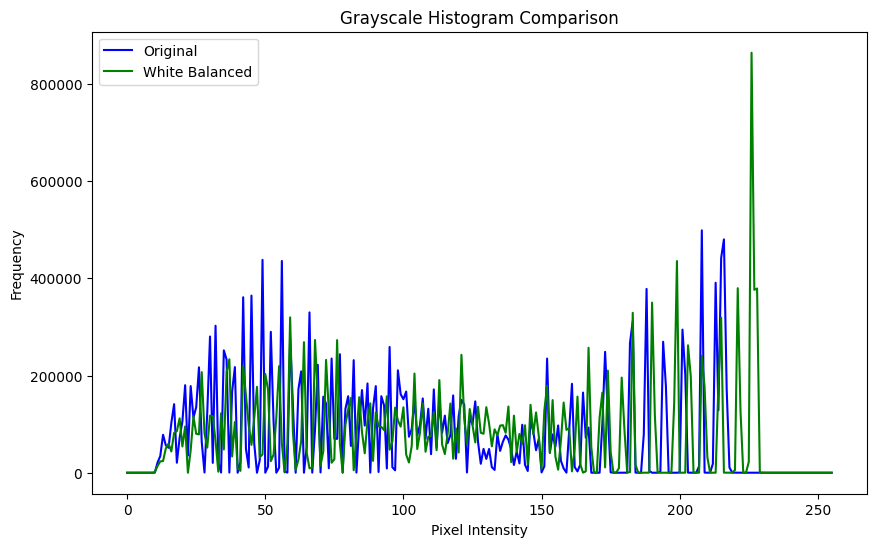

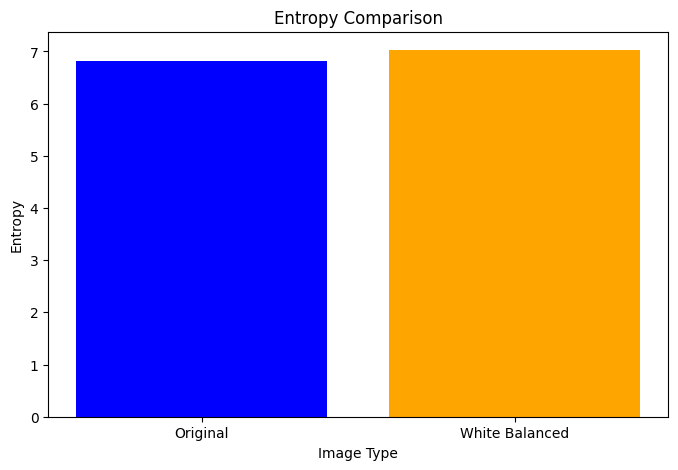

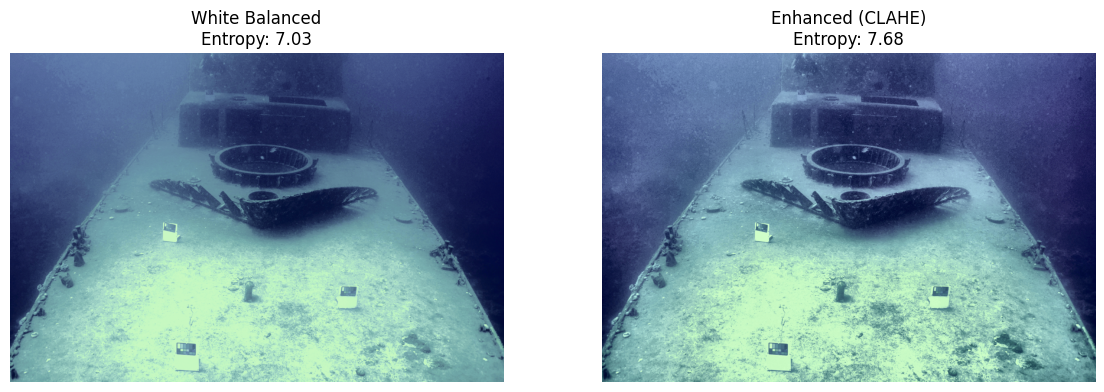

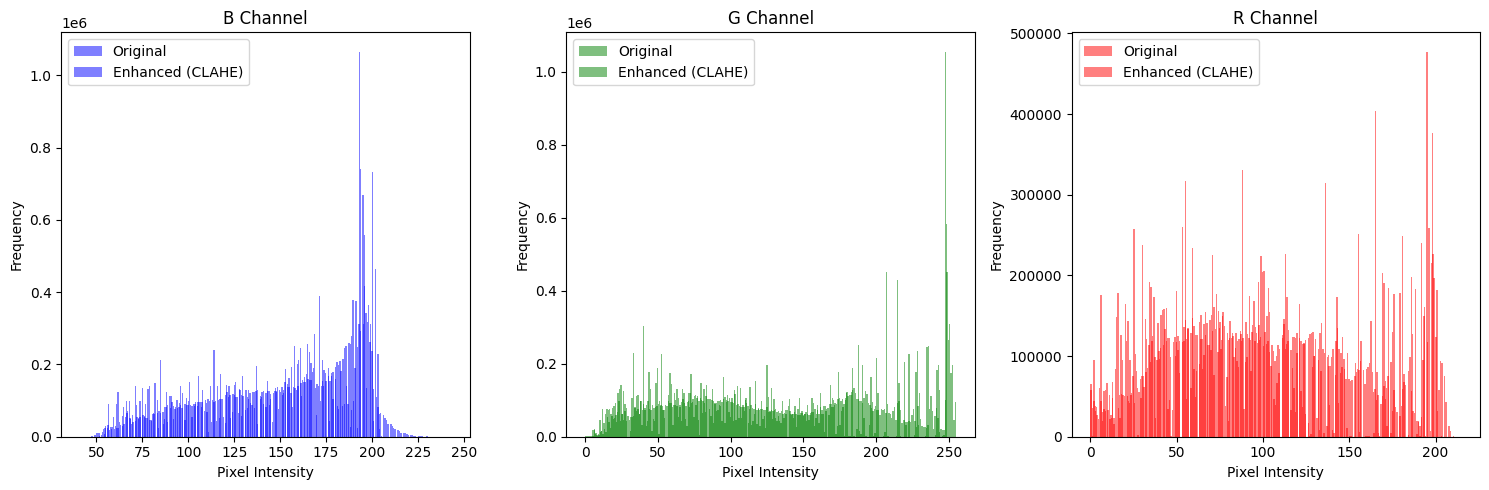

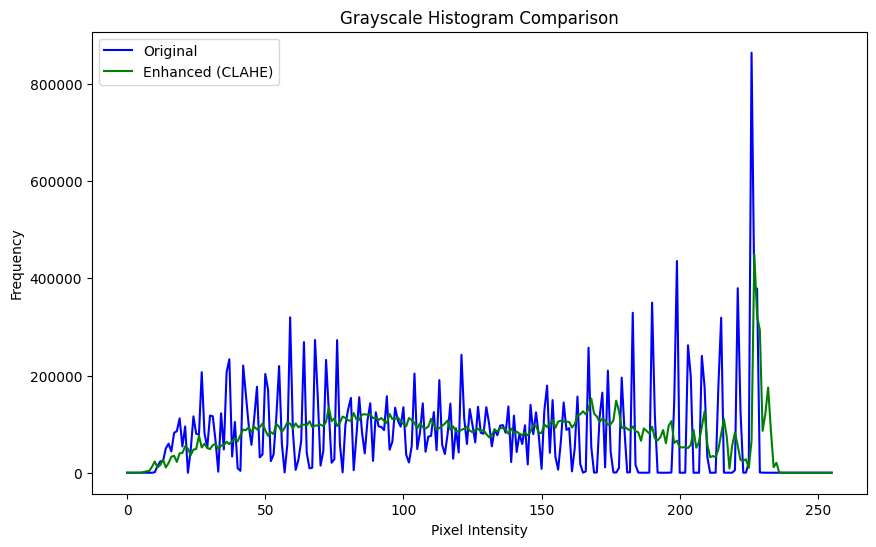

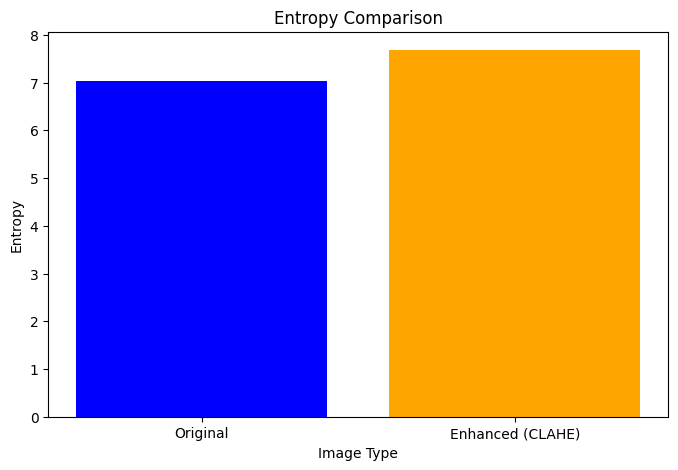

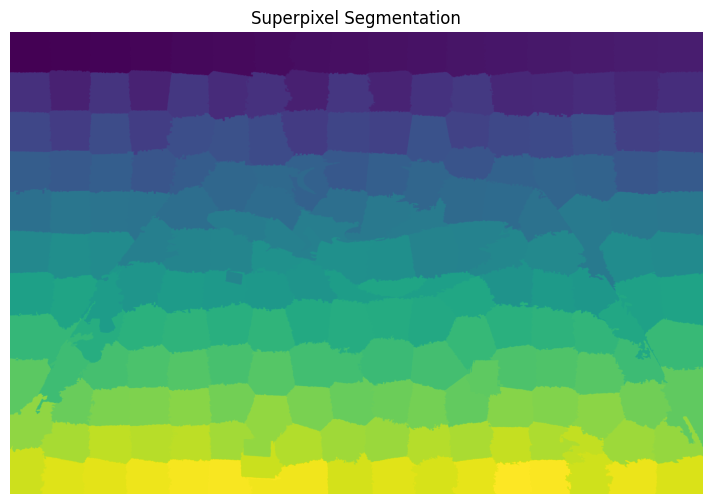

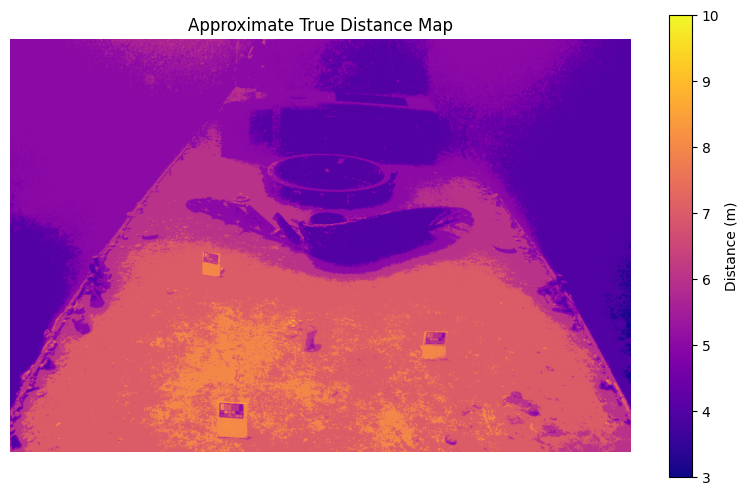

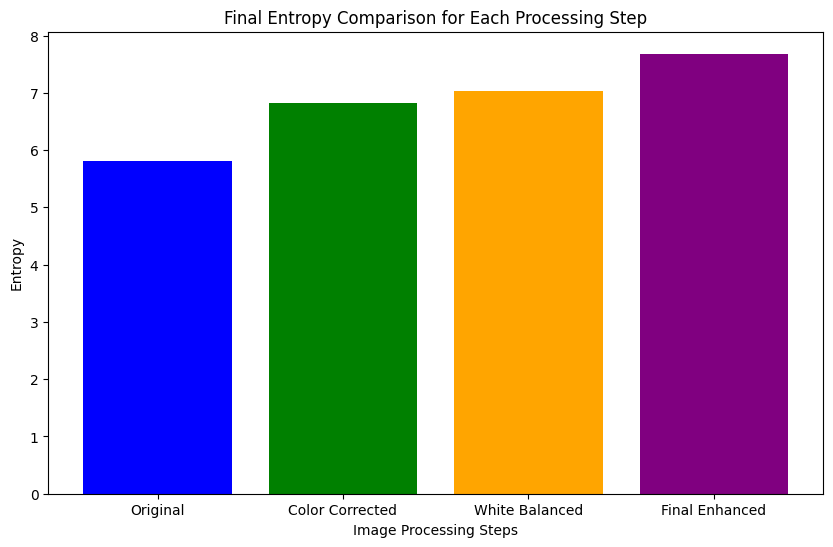

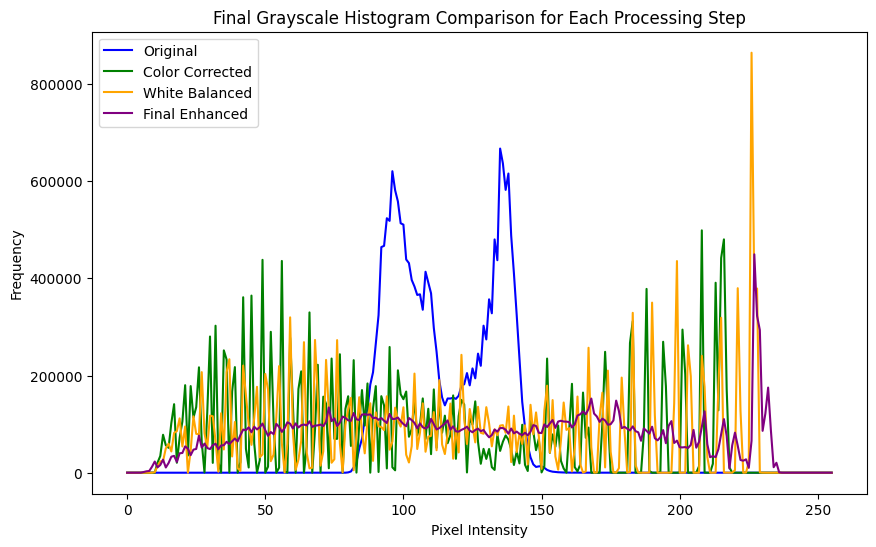

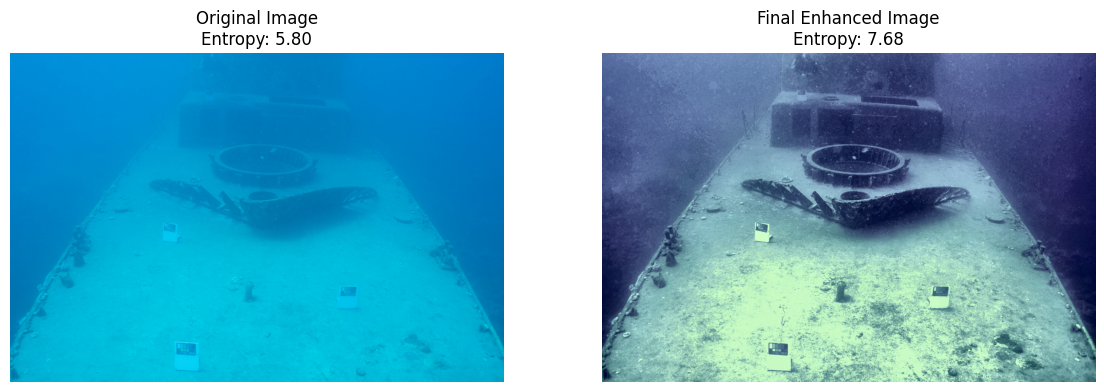

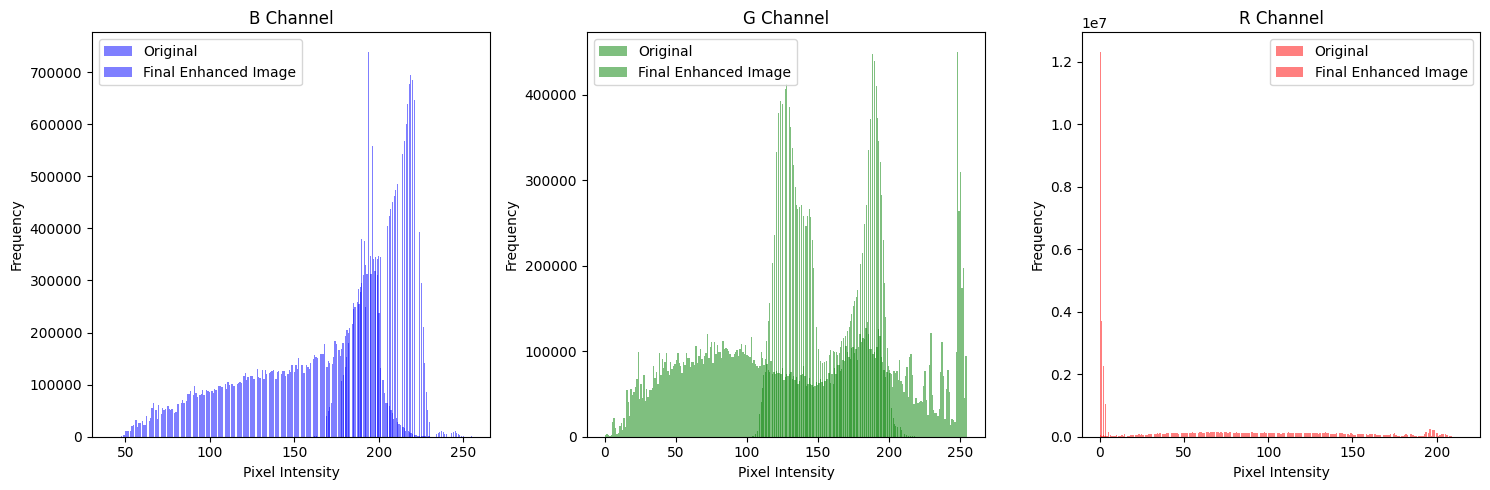

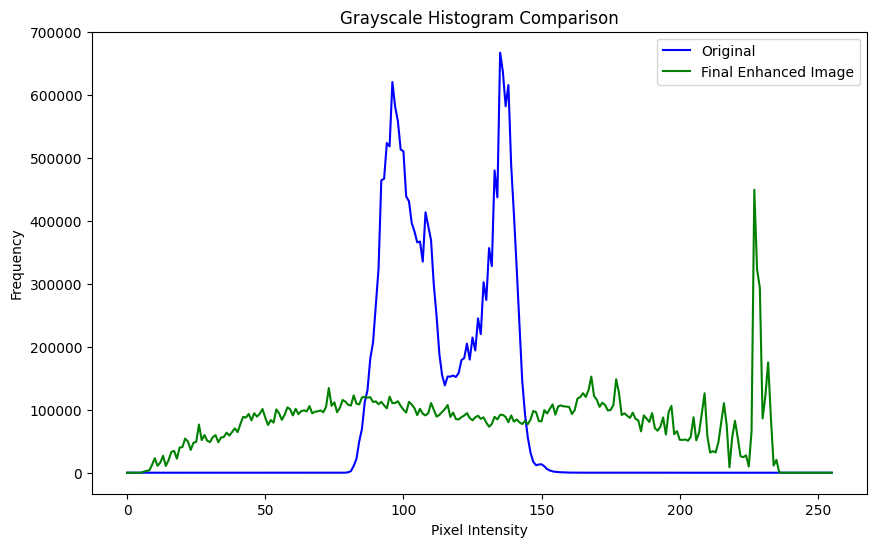

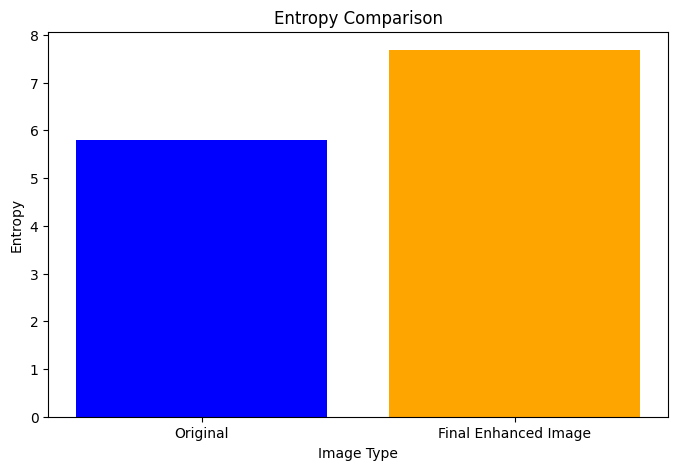

Entropy of Original Image: 5.804922
Entropy of Color Corrected Image: 6.8171115
Entropy of White Balanced Image: 7.0259266
Entropy of Final Enhanced Image: 7.6826897


In [7]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.segmentation import slic
from skimage.color import rgb2lab

# Upload and load the image
uploaded = files.upload()
input_image_path = list(uploaded.keys())[0]
input_image = cv2.imread(input_image_path)

# Function to calculate entropy of an image
def calculate_entropy(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    log_hist = np.log2(hist + 1e-10)
    entropy = -np.sum(hist * log_hist)
    return entropy

# Function for color correction
def color_correct(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab_image)
    l = cv2.equalizeHist(l)
    corrected_image = cv2.merge((l, a, b))
    corrected_image = cv2.cvtColor(corrected_image, cv2.COLOR_LAB2BGR)
    return corrected_image

# Function to apply white balance
def white_balance(image):
    result = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

# Function for contrast enhancement using CLAHE
def apply_clahe(image, clip_limit=3.0, grid_size=(8, 8)):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    enhanced_image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    return enhanced_image

# Function to perform SLIC superpixel segmentation
def superpixel_segmentation(image):
    segments = slic(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), n_segments=200, compactness=10)
    return segments

# Function to estimate true distance based on brightness
def approximate_true_distance(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel = lab_image[:, :, 0]
    min_distance, max_distance = 3, 10
    norm_l = cv2.normalize(l_channel, None, min_distance, max_distance, cv2.NORM_MINMAX)
    return norm_l

# Helper function to plot comparisons
def plot_comparison(original, processed, title_original, title_processed, entropy_original, entropy_processed):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title(f'{title_original}\nEntropy: {entropy_original:.2f}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title(f'{title_processed}\nEntropy: {entropy_processed:.2f}')
    plt.axis('off')
    plt.show()

    # RGB channel comparison histograms
    plt.figure(figsize=(15, 5))
    for i, color in enumerate(['b', 'g', 'r']):
        plt.subplot(1, 3, i+1)
        plt.hist(original[:, :, i].ravel(), bins=256, color=color, alpha=0.5, label='Original')
        plt.hist(processed[:, :, i].ravel(), bins=256, color=color, alpha=0.5, label=title_processed)
        plt.title(f'{color.upper()} Channel')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Grayscale histogram comparison
    plt.figure(figsize=(10, 6))
    hist_orig = cv2.calcHist([cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256])
    hist_proc = cv2.calcHist([cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256])

    plt.plot(hist_orig, color='blue', label='Original')
    plt.plot(hist_proc, color='green', label=title_processed)
    plt.title('Grayscale Histogram Comparison')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Entropy comparison
    plt.figure(figsize=(8, 5))
    plt.bar(['Original', title_processed], [entropy_original, entropy_processed], color=['blue', 'orange'])
    plt.xlabel('Image Type')
    plt.ylabel('Entropy')
    plt.title('Entropy Comparison')
    plt.show()

# Process and display each enhancement step
if input_image is None:
    print(f"Error: Unable to load image '{input_image_path}'")
else:
    # Calculate entropy for the original image
    entropy_original = calculate_entropy(cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY))

    # 1) Original vs Color Corrected
    color_corrected_image = color_correct(input_image)
    entropy_color_corrected = calculate_entropy(cv2.cvtColor(color_corrected_image, cv2.COLOR_BGR2GRAY))
    plot_comparison(input_image, color_corrected_image, 'Original Image', 'Color Corrected', entropy_original, entropy_color_corrected)

    # 2) Color Corrected vs White Balanced
    white_balanced_image = white_balance(color_corrected_image)
    entropy_white_balanced = calculate_entropy(cv2.cvtColor(white_balanced_image, cv2.COLOR_BGR2GRAY))
    plot_comparison(color_corrected_image, white_balanced_image, 'Color Corrected', 'White Balanced', entropy_color_corrected, entropy_white_balanced)

    # 3) White Balanced vs CLAHE Enhanced
    clahe_image = apply_clahe(white_balanced_image)
    entropy_clahe = calculate_entropy(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2GRAY))
    plot_comparison(white_balanced_image, clahe_image, 'White Balanced', 'Enhanced (CLAHE)', entropy_white_balanced, entropy_clahe)

    # Superpixel Segmentation
    segments = superpixel_segmentation(input_image)
    plt.figure(figsize=(10, 6))
    plt.imshow(segments, cmap='viridis')
    plt.title('Superpixel Segmentation')
    plt.axis('off')
    plt.show()

    # True Distance Map
    distance_map = approximate_true_distance(input_image)
    plt.figure(figsize=(10, 6))
    plt.imshow(distance_map, cmap='plasma')
    plt.colorbar(label='Distance (m)')
    plt.title('Approximate True Distance Map')
    plt.axis('off')
    plt.show()

    # Final Entropy Comparison Chart
    entropy_values = [entropy_original, entropy_color_corrected, entropy_white_balanced, entropy_clahe]
    labels = ['Original', 'Color Corrected', 'White Balanced', 'Final Enhanced']

    plt.figure(figsize=(10, 6))
    plt.bar(labels, entropy_values, color=['blue', 'green', 'orange', 'purple'])
    plt.xlabel('Image Processing Steps')
    plt.ylabel('Entropy')
    plt.title('Final Entropy Comparison for Each Processing Step')
    plt.show()

    # Final Grayscale Histogram Comparison
    plt.figure(figsize=(10, 6))
    plt.plot(cv2.calcHist([cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256]), color='blue', label='Original')
    plt.plot(cv2.calcHist([cv2.cvtColor(color_corrected_image, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256]), color='green', label='Color Corrected')
    plt.plot(cv2.calcHist([cv2.cvtColor(white_balanced_image, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256]), color='orange', label='White Balanced')
    plt.plot(cv2.calcHist([cv2.cvtColor(clahe_image, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256]), color='purple', label='Final Enhanced')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Final Grayscale Histogram Comparison for Each Processing Step')
    plt.legend()
    plt.show()

    # Display final comparison of Original vs Final Enhanced Image
    plot_comparison(input_image, clahe_image, 'Original Image', 'Final Enhanced Image', entropy_original, entropy_clahe)

    # Display final entropy values
    print("Entropy of Original Image:", entropy_original)
    print("Entropy of Color Corrected Image:", entropy_color_corrected)
    print("Entropy of White Balanced Image:", entropy_white_balanced)
    print("Entropy of Final Enhanced Image:", entropy_clahe)